### 1. Since the data are all numerical, I'll work it as the mutiple linear regression
I'll first build a MLR baseline model to predict "charges" 

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers
import streamlit as st
import pickle, joblib
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [240]:
# 1. Load the data
import pandas as pd

# Load the CSV file
df = pd.read_csv("medical_insurance.csv")

# Optional: take a quick look at the data
print(df.head())
print(df.info())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB
None


Convert categorical variable to numerical, by using pd.get_dummies(), to approach for Linear Regression, Gradient Descent, Scikit-learn models. 
- Converting to numerical is necessary 

In [241]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)


# Separate features and target
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

# Add feature scaling before polynomial features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Then create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
poly_feature_names = poly.get_feature_names_out(X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [242]:
num_cols  = ['age','bmi','children']
cat_cols  = ['sex','smoker','region']

preprocess = ColumnTransformer(
      transformers=[
          ('num', StandardScaler(), num_cols),
          ('cat', OneHotEncoder(drop='first'), cat_cols)
      ],
      remainder='drop'
)

rf = RandomForestRegressor(random_state=42)

pipe = Pipeline(steps=[('prep', preprocess),
                      ('model', rf)])

param_grid = {
    'model__n_estimators': [200,300,500],
    'model__max_depth':   [None,10,20,30]
}

search = RandomizedSearchCV(pipe, param_grid,
                            n_iter=8, cv=5,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1, random_state=42)

search.fit(X, y)
rf_best = search.best_estimator_

# save artefacts for UI & later analysis
with open("rf_model.pkl","wb") as f: pickle.dump(rf_best,f)
with open("preprocess.pkl","wb") as f: pickle.dump(preprocess,f)
pickle.dump(list(rf_best['prep'].get_feature_names_out()),
            open("feature_names.pkl","wb"))


ValueError: 
All the 40 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 153, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 182, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'sex'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/_indexing.py", line 364, in _get_column_indices
    col_idx = all_columns.get_loc(col)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3809, in get_loc
    raise KeyError(key) from err
KeyError: 'sex'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py", line 588, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/pipeline.py", line 1551, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 993, in fit_transform
    self._validate_column_callables(X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 552, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/_indexing.py", line 372, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


- " Drop_first " Tells Pandas to drop the first category of each variable (alphabetically), so only the other categories are kept as dummy variables. -> To avoid multicollinearity 
- We now drop the sex_female, smoker_no, and region_southwest here, but we don't necessarily have to explicitly bring them back when training model. Because the model remember what 0 is here. 

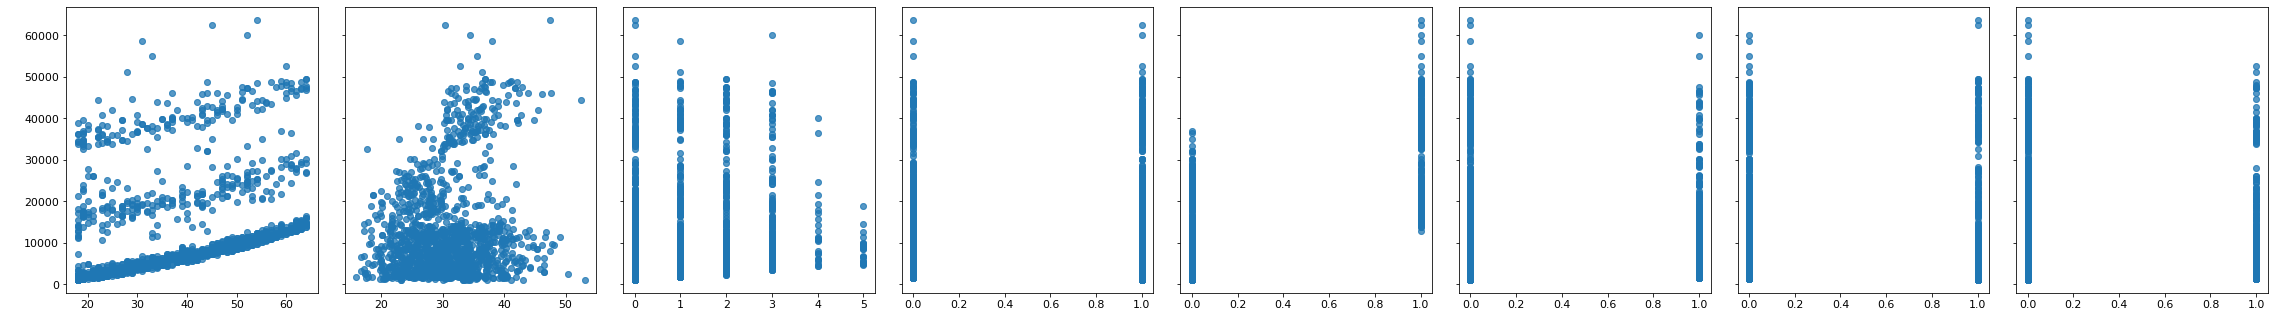

In [205]:
# Separate features and target
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]

#X_features = df_encoded.drop("charges", axis=1).columns
#X_features = X.columns

# Correct way to get the feature names
feature_names = df_encoded.drop("charges", axis=1).columns

# Plot each feature against charges
fig, ax = plt.subplots(1, len(feature_names), figsize=(4 * len(feature_names), 5), sharey=True)

for i in range(len(feature_names)):
    ax[i].scatter(X[feature_names[i]], y, alpha=0.5)
    ax[i].set_xlabel(feature_names[i], color = 'white', fontsize=13)
    ax[i].tick_params(axis='both', labelsize=11)                  # ← larger tick font
    if i == 0:
        ax[i].set_ylabel("Charges", color='white', fontsize=13)
    

plt.tight_layout(pad=2)
plt.show()


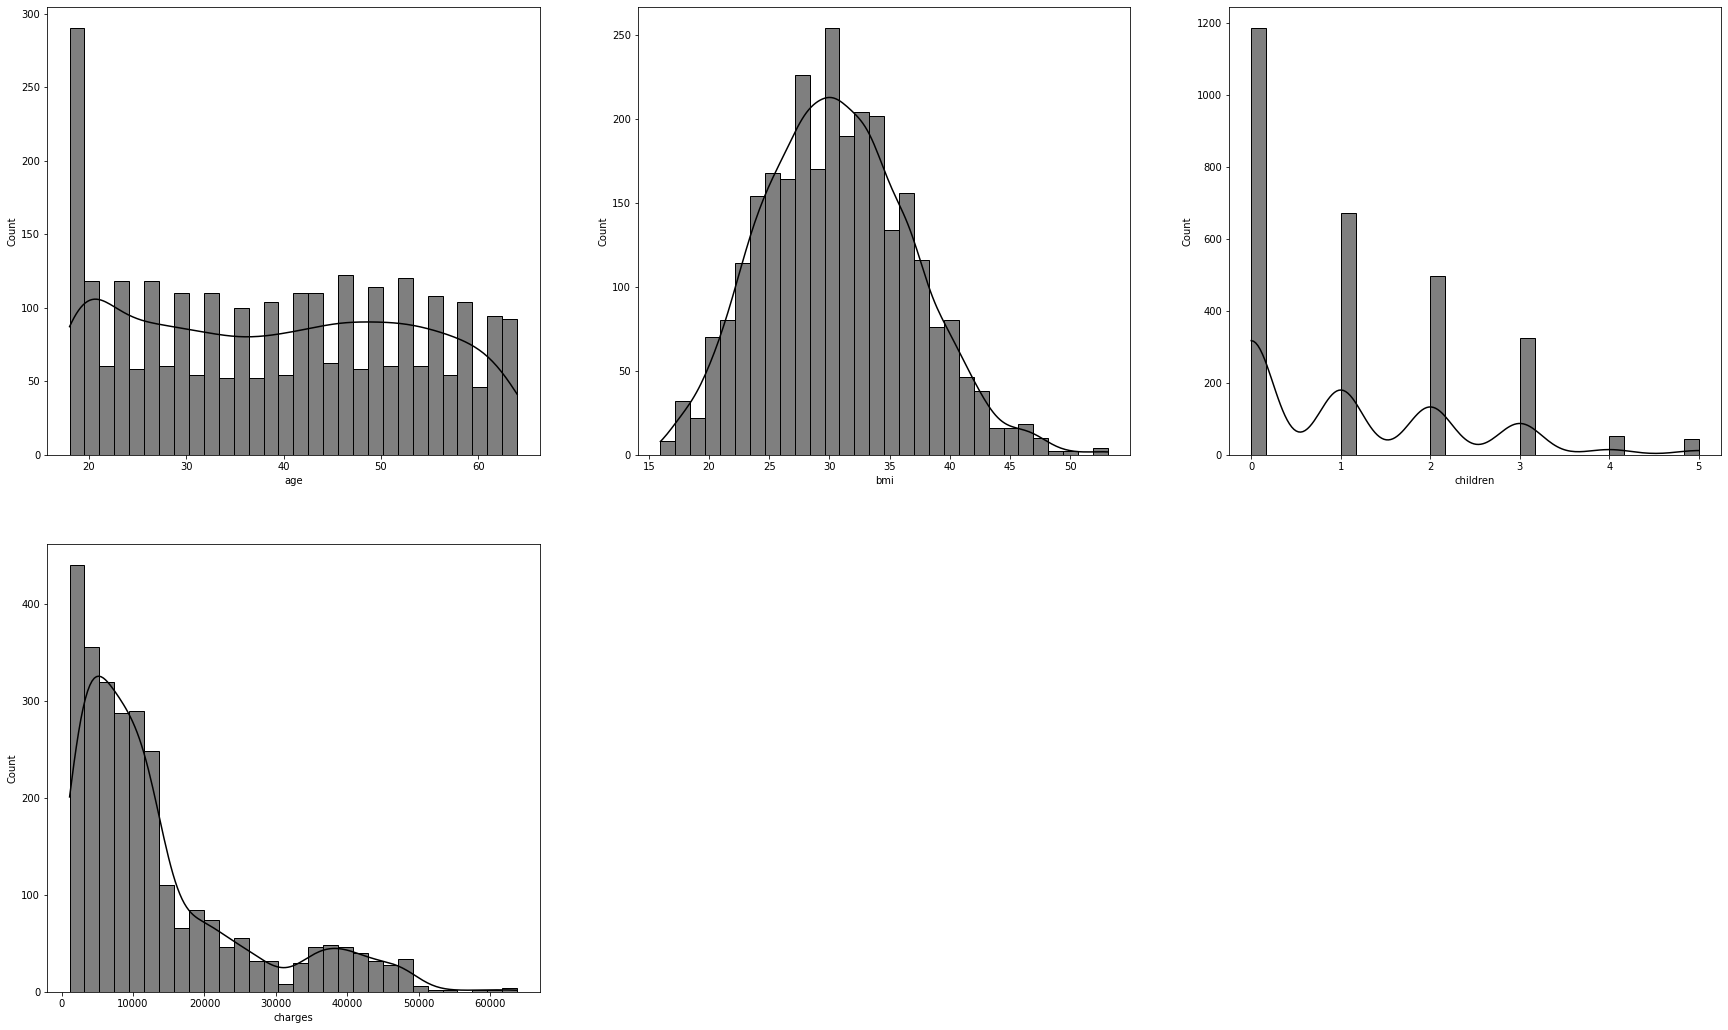

In [206]:
plt.figure(figsize=(30,28))
for i, col in enumerate( ['age','bmi','children','charges']):
    plt.subplot(3, 3, i+1)
    sns.histplot(data = df,
            x = col,
            kde = True,
            bins = 30,
            color = 'black')

plt.show()

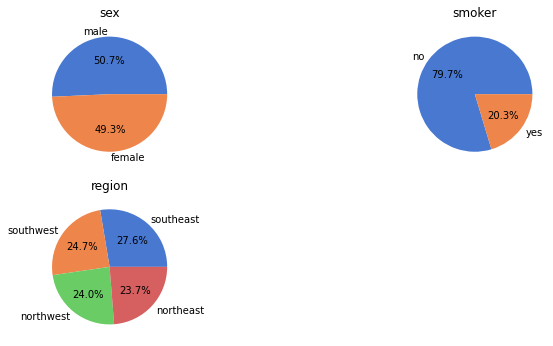

In [ ]:
plt.figure(figsize=(12,9))
for i,col in enumerate(['sex','smoker','region']):
    plt.subplot(3,2,i+1)
    x=df[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

We get the insight here that 
1. older people tend to cost more
2. bmi flat with some outliers

In [208]:
# 2. Visualize data and check missed value

print(df.describe())
print(df.isnull().sum())
print(df['sex'].unique(), df['smoker'].unique(), df['region'].unique())

# Convert categorical variables to numeric using one-hot encoding.
df_encoded = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)


               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
['female' 'male'] ['yes' 'no'] ['southwest' 'southeast' 'northwest' 'northeast']


### Train with Sklearn -SDGRegressor

In [209]:
# Add feature scaling before polynomial features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [212]:
# Feature scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# After training your best model (rf_best)
from sklearn.model_selection import cross_val_score

# Add cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_best, X_poly, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-validated RMSE: {-cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

In [213]:
# Create and train SGD Regressor model
sgdr = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42)
sgdr.fit(X_train_scaled, y_train)

# View learned parameters
weights = sgdr.coef_
intercept = sgdr.intercept_

# Make predictions
y_pred = sgdr.predict(X_test_scaled)

# Evaluate model
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr= np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred)

# Display results
results = {
    "RMSE": rmse_lr,
    "R² Score": r2_lr,
    "Weights": weights,
    "Intercept": intercept
}

results

{'RMSE': 5027.286939989997,
 'R² Score': 0.835330620540762,
 'Weights': array([ 3.53333699e+03,  1.92158428e+03,  8.56934673e+02, -1.50719751e+02,
         4.85093169e+03, -9.34376129e+01, -8.49849611e+01, -9.09570295e+01,
         6.84209221e+02,  7.67032317e+01, -1.33523705e+02,  1.01917467e+02,
        -1.17312871e+02, -5.18487337e+01,  1.54760932e+02,  2.46977927e+02,
        -2.53004698e+02,  1.32783599e+02,  8.85415450e+01,  3.64336059e+03,
        -7.55478982e+01, -4.94478230e+02, -2.44053158e+02, -1.72704413e+02,
        -1.64868972e+02, -2.28528706e+02,  5.50691318e+01, -2.48010660e+02,
        -2.75923649e+02,  1.50719751e+02, -6.89411192e+00, -1.82127679e+00,
         3.66961737e+01,  2.65403653e+00,  4.85093169e+03, -9.06992183e+01,
        -1.62491716e+02,  2.40660612e+02, -9.34376129e+01,  1.55902195e+02,
         1.58536991e+02, -8.49849611e+01,  1.54140942e+02, -9.09570295e+01]),
 'Intercept': array([13385.98616992])}

In [ ]:
# After training rf_best
from sklearn.feature_selection import SelectFromModel

# Use feature importance for feature selection
selector = SelectFromModel(rf_best, prefit=True)
X_selected = selector.transform(X_poly)

# You can then retrain your model with selected features
rf_selected = RandomForestRegressor(**rf_best.get_params())
rf_selected.fit(X_selected, y)

### Train with Tensorflow - Deep Learning

In [214]:
# Add polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

In [215]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [216]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_test_scaled, y_test),
                    epochs=100, batch_size=32, verbose=1)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 314985088.0000 - root_mean_squared_error: 17742.6289 - val_loss: 317432992.0000 - val_root_mean_squared_error: 17816.6484
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 336012096.0000 - root_mean_squared_error: 18329.0273 - val_loss: 314762976.0000 - val_root_mean_squared_error: 17741.5605
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 317535072.0000 - root_mean_squared_error: 17818.2734 - val_loss: 306303072.0000 - val_root_mean_squared_error: 17501.5156
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 320563776.0000 - root_mean_squared_error: 17889.2422 - val_loss: 289353728.0000 - val_root_mean_squared_error: 17010.4004
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 293773024.0000 - root_mean_squared_error: 17137.2188 - val_loss: 262856480.0000 - val_root_mean_squared_error: 16212.8496
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 252368688.0000 - root_mean

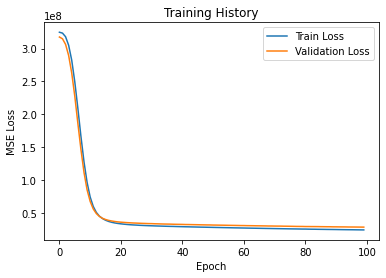

In [219]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.show()

In [ ]:
# After training your best model (rf_best)
from sklearn.model_selection import cross_val_score

# Add cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_best, X_poly, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-validated RMSE: {-cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

In [ ]:
# After training rf_best
from sklearn.feature_selection import SelectFromModel

# Use feature importance for feature selection
selector = SelectFromModel(rf_best, prefit=True)
X_selected = selector.transform(X_poly)

# You can then retrain your model with selected features
rf_selected = RandomForestRegressor(**rf_best.get_params())
rf_selected.fit(X_selected, y)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Neural Network Evaluation:
RMSE = 5353.68
R^2 Score = 0.813


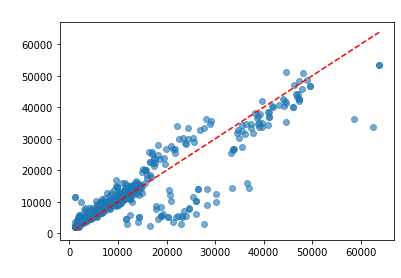

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_pred)
# Manually compute RMSE
mse_nn= mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred)

print(f"\nNeural Network Evaluation:\nRMSE = {rmse_nn:.2f}\nR^2 Score = {r2_nn:.3f}")


# Plot predictions vs actuals
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Charges", color = 'white')
plt.ylabel("Predicted Charges", color = 'white')
plt.title("Actual vs Predicted Medical Charges", color = 'white')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

In [221]:
print("Neural Network:")
print(f"  RMSE = {rmse_nn:.2f}, R² = {r2_nn:.3f}")
print("Linear Regression (Sklearn):")
print(f"  RMSE = {rmse_lr:.2f}, R² = {r2_lr:.3f}")

Neural Network:
  RMSE = 5353.68, R² = 0.813
Linear Regression (Sklearn):
  RMSE = 5027.29, R² = 0.835


- Since RMSE measures error (lower is better) and R² measures the proportion of variance explained (higher is better), linear regression is the better model here — even though neural networks are generally more flexible, in this case the relationship between features and charges seems fairly linear, and thus linear regression fits it well without needing complex architectures.


### Train with Random Forest
Random Forest can help:
- Capture non-linear relationships (in case insurance cost increases non-linearly with age, BMI, etc.).
- Handle feature interactions automatically (e.g., maybe 'smoker' and 'age' together have a big combined effect).
- Reduce overfitting compared to a single Decision Tree (by averaging many trees).

In [222]:
# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=100,  
    max_depth=None,    
    random_state=42
)



In [ ]:
# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [224]:
# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

In [225]:
# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest:\n RMSE = {rmse_rf:.2f}, R² = {r2_rf:.3f}")

Random Forest:
 RMSE = 2739.24, R² = 0.951


Random Forest has the lowest RMSE and highest R², which is the best performance!

### Automated hyper-parameter search - Random-Forest Grid Search

In [ ]:

# parameter grid 
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt"]
}

rf = RandomForestRegressor(random_state=42)
gcv = GridSearchCV(
    rf,
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)
gcv.fit(X_train, y_train)

print("Best params ➜", gcv.best_params_)
print(f"CV RMSE      ➜ {-gcv.best_score_:.0f}")

# keep the tuned model
rf_best = gcv.best_estimator_
pickle.dump(rf_best, open("rf_model.pkl", "wb"))  # overwrite old model


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END max_depth=N

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
84 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10

Best params ➜ {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
CV RMSE      ➜ 3048


### Quick feature-importance view

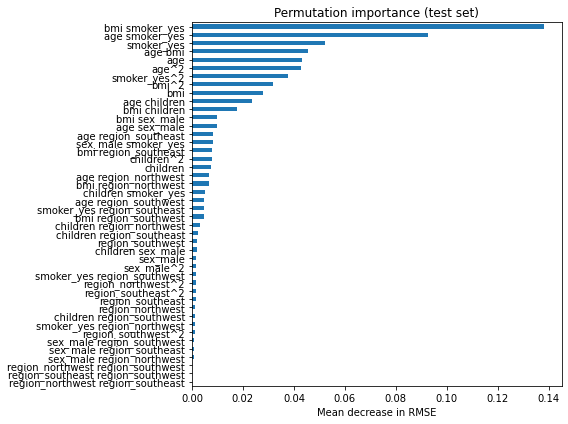

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Permutation importance on test set
result = permutation_importance(
    rf_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

result = permutation_importance(
    rf_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=poly_feature_names)

importances.sort_values().plot.barh(figsize=(8,6))
plt.title("Permutation importance (test set)")
plt.xlabel("Mean decrease in RMSE")
plt.tight_layout()
plt.show()


### Save file for UI

In [229]:
# Save the trained Random Forest model
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

# Save the trained Scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Save the feature names (after preprocessing)
pickle.dump(feature_names, open('feature_names.pkl', 'wb'))
